In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
#from apyori import apriori 

In [2]:
#load data

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))

#df=pd.read_csv('week1processed.csv',  parse_dates=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [4]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [5]:
df.head()

Date  Duration          Src_IP  Src_pt          Dst_IP  \
0 2017-08-02 00:00:00.419     0.003  192.168.210.55   44870  192.168.100.11   
1 2017-08-02 00:00:00.421     0.000  192.168.100.11     445  192.168.210.55   
2 2017-08-02 00:00:02.593     0.004  192.168.220.47   55101  192.168.100.11   
3 2017-08-02 00:00:02.859     0.000        10000_34     443  192.168.210.54   
4 2017-08-02 00:00:02.594     0.000  192.168.100.11     445  192.168.220.47   

    Dst_pt  Packets     Bytes    date_hr                             pairs  \
0    445.0        2       174 2017-08-02  [192.168.100.11, 192.168.210.55]   
1  44870.0        1       108 2017-08-02  [192.168.100.11, 192.168.210.55]   
2    445.0        2       174 2017-08-02  [192.168.100.11, 192.168.220.47]   
3  59628.0        1       100 2017-08-02        [10000_34, 192.168.210.54]   
4  55101.0        1       108 2017-08-02  [192.168.100.11, 192.168.220.47]   

                             pairs2  norm_latency  
0  (192.168.100.11, 192.168.210.55)        0.0015  
1  (192.168.100.11, 192.168.210.55)        0.0000  
2  (192.168.100.11, 192.168.220.47)        0.0020  
3        (10000_34, 192.168.210.54)        0.0000  
4  (192.168.100.11, 192.168.220.47)        0.0000

## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

### 1. Data manipulation

The fp-growth function requires the data be a list of lists, where each list is an individual "transaction" or in our case IP pair request

In [6]:
#we only want a list of all the individual pairs at each timestamp. Think of this where each timestamp is a 'transaction' and we chose to buy which 2 items (IP addresses)
data_l=list(df['pairs'])
 #this list contains each transaction or timestamp, where many itemsets are repeated

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

In [7]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [8]:
pairs_count.head()

pairs  frequency  avg_norm_latency  total_duration  \
0   (0.0.0.0, 255.255.255.255)        123          0.018820           6.801   
1  (10000_163, 192.168.220.47)         16          0.026500           6.378   
2   (10000_34, 192.168.210.45)         96          0.022706          23.679   
3   (10000_34, 192.168.210.46)        165          0.014315          28.699   
4   (10000_34, 192.168.210.47)        433          0.020122          77.542   

   total_packets  norm_latency  
0            223      0.000004  
1            204      0.000003  
2            723      0.000013  
3            971      0.000016  
4           1739      0.000042

In [9]:
#df[ (df['Src_IP']=='192.168.210.55')& (df['Dst_IP']=='192.168.100.11')]
#select 1 pair to see how it changes through time

Text(0,0.5,'Frequency of occurance')

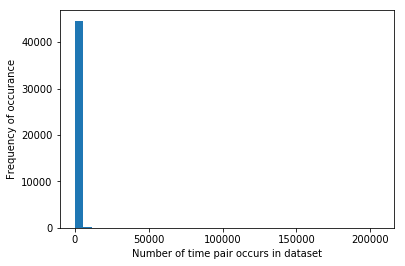

In [10]:
plt.hist(pairs_count['frequency'], bins=35)
plt.xlabel('Number of time pair occurs in dataset')
plt.ylabel('Frequency of occurance')

Whew, this dataset is varied! We definitely want our minimum threshold to be below 200,000 (min=200,000)

Are the pairs that occur frequently likely to have higher or lower latency?

Text(0.5,0,'IP pair frequency of occurance')

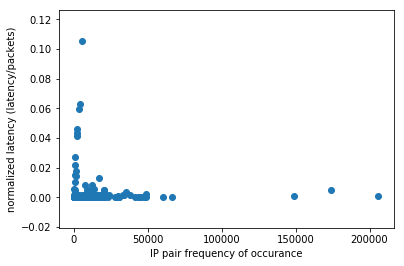

In [11]:
plt.scatter(pairs_count['frequency'], pairs_count['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.02)

### We will pick a very low min threshold so many rules are created

Then, we can filter though the rules based on these values and see how many rules would have been created if we had selected a more stringent threshold.


In [8]:
per_20=np.percentile(pairs_count['frequency'], [20])[0] #the value that represents the 20th percentile for frequency of pairs occuring. the 20th percentile is the value (or score) below which 20% of the observations (how frequently a pair occurs) may be found.  
per_40=np.percentile(pairs_count['frequency'], [40])[0]
per_60=np.percentile(pairs_count['frequency'], [60])[0]
per_80=np.percentile(pairs_count['frequency'], [80])[0]


In [18]:
per_80/len(df) #this pair occurs this % in the dataset, this is the value Apriori would use for it's min threshold

array([1.5392148e-05])

In [9]:
patterns_20 = pyfpgrowth.find_frequent_patterns(data_l, per_20) 
#we set the min threshold of frequency occurance equal to the 80th percentile of frequency, this will only return results where the pair exists above the 80th percentile, a relatively small amount.
#this has to be a whole number and is dependent on the dataset size, thus picking a percentile helps us know what that number means.

In [91]:
len(patterns)

11015

In [12]:
confidence=0.2 #this means the rule is likely to be true 20% of the time, it is a high threshold, used for testing
rules_20per_20con = pyfpgrowth.generate_association_rules(patterns_20, confidence)

### Generate Rules from the most frequent items we found

Bring in the frequency of each rule and sum of the normalized latency. Use these metrics to prioritize the rules we will implement. There is always a tradeoff withh implementing more rules, so we want to be efficient.

In [14]:
#the input 'rules' is the result of the pyfgrowth function run above. You must have specified the thresholds you want to use
#the orig_df is the original data, with 
#the apps_server is the number of apps that can fit on a server
def format_rules(rules, orig_df,apps_server): 
    #Convert the Dictionary format into a dataframe
    rules_df=pd.DataFrame(list(rules.items()), columns=['IP_A', 'confidence'])
    rules_df['confidence']=rules_df['confidence'].astype(str)

    rules_df['IP_B'], rules_df['B'] = rules_df['confidence'].str.split(', ', 1).str
    rules_df=rules_df.drop('confidence', axis=1)
    rules_df.IP_B=rules_df.IP_B.astype(str)
    rules_df.IP_A=rules_df.IP_A.astype(str)
    rules_df.columns=['IP_A', 'IP_B', 'confidence']
    rules_df[['IP_A', 'IP_B']]=rules_df[['IP_A', 'IP_B']].replace({',':''}, regex=True)

    rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip('(').rstrip(')'))
    rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip('((').rstrip(')'))
    rules_df['confidence'] = rules_df['confidence'].map(lambda x: x.rstrip(')'))
    rules_df['IP_A'] = rules_df['IP_A'].map(lambda x: x.lstrip("'").rstrip("'"))
    rules_df['IP_B'] = rules_df['IP_B'].map(lambda x: x.lstrip("'").rstrip("'"))
    
    #add back in a pairs column, this is important because the order of IP_A and IP_B does not matter, 
    rules_df['pairs']=list(zip(rules_df.IP_A, rules_df.IP_B))
    rules_df['pairs']=rules_df['pairs'].apply(sorted)
    rules_df['pairs2']=tuple(rules_df['pairs'])
    
    pairs_count=(orig_df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
    pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
    pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair
    
    rules_df=rules_df.merge(pairs_count, left_on='pairs2', right_on='pairs')
    rules_df=rules_df.drop('pairs_y', axis=1)
    rules_df=rules_df.rename(columns={'pairs_x':'pairs'})
    rules_df['latency_rank']=rules_df['frequency']*rules_df['norm_latency']
    
    rules_df=rules_df.sort_values(by='latency_rank', ascending=False)
    
    #1. Start by filling in the servers on the pairs until the server is full
    import math
    pairs_server=apps_server/2 #pairs of IP addresses that can fit on each server

#how many servers do we need for our rules, which are in pairs?
    servers_rule=math.ceil(len(rules_df)/pairs_server)
    servers_rule_list=list(range(0,servers_rule+1))
    servers_rule_list=np.repeat(servers_rule_list,pairs_server)

#remove the extra items
    servers_rule_list=servers_rule_list[0:len(rules_df)]
    
    # add a pair_ID column so we can keep track of how frequently IP addresses repeat in different pairs
    rules_df['pair_ID']=range(0, len(rules_df))
    
    #start by assigning the most important pair to a server
    rules_df['server_A']=None
    rules_df['server_B']=None
    rules_df['server_A'][0]=0
    rules_df['server_B'][0]=0
    
    #assign these servers to the pairs in our rules dataframe. Again this is stupid as we are not considering individual IPs that may repeat in different pairs. but it's a start
    rules_df['server']=servers_rule_list
    #export rules_df
    rules_df.to_csv('rules_df.csv')

    return(rules_df)

In [15]:
rules_df_20per_20con=format_rules(rules_20per_20con, df, 20)
rules_df_20per_20con.head()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


IP_A            IP_B confidence                        pairs  \
3068  13053_118  192.168.210.56        1.0  [13053_118, 192.168.210.56]   
3057  13049_193  192.168.210.56        1.0  [13049_193, 192.168.210.56]   
3062  13053_106  192.168.210.56        1.0  [13053_106, 192.168.210.56]   
3066   10272_44  192.168.220.51        1.0   [10272_44, 192.168.220.51]   
3064   14170_51  192.168.220.51        1.0   [14170_51, 192.168.220.51]   

                           pairs2  frequency  avg_norm_latency  \
3068  (13053_118, 192.168.210.56)      12439          0.255143   
3057  (13049_193, 192.168.210.56)       1775          0.372031   
3062  (13053_106, 192.168.210.56)       7180          0.343261   
3066   (10272_44, 192.168.220.51)      10094          0.091117   
3064   (14170_51, 192.168.220.51)       8094          0.022052   

      total_duration  total_packets  norm_latency  latency_rank  pair_ID  \
3068       15736.067          44427      0.008610    107.096797        0   
3057       79345.558         245786      0.043413     77.057656        1   
3062       14717.209          31305      0.008052     57.815558        2   
3066        3665.353          26275      0.002005     20.242956        3   
3064        1881.134          26460      0.001029      8.330628        4   

     server_A server_B  server  
3068     None     None       0  
3057     None     None       0  
3062     None     None       0  
3066     None     None       0  
3064     None     None       0

### now plot the normalized latency vs frequency and see if we have any trends

Text(0.5,0,'IP pair frequency of occurance')

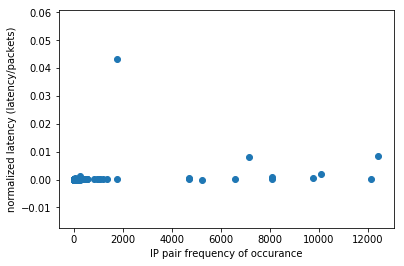

In [52]:
plt.scatter(rules_df['frequency'], rules_df['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.015)

#### Comparing this plot to the earlier plot of all IP pairs, we see two things:
    1. the left arm on the plot with all datapoints at the x-axis=0 is gone, this indicates that the model did not allow IP pairs with very low frequency. This is intuitive because of the min threshold we set for 'support' (which is simply frequency) equal to xx.
    2. The x-axis is significantly shorter than the plot with all datapoints. This is due to the 'confidence' threshold we selected when creating the rules. This means that it is hard for the model to be as certain that an IP is likely to co-occur at higher frequency. This is counter intuitive, but is likely explained by the definition of confidience: frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. Even if a pair has a high frequency of occuring, the frequency of X alone might be so great that it drowns out the signal of detecting the pair.
    

Simple ranking approach:
    Multiply the pair frequency of occurance by the normal latency duration time for that pair. We are simply giving higher priority to pairs that are slow, so even if they are not that frequent they will still be ranked higher because we have more to gain by co-locating them and reducing latency. 
    
    for example if pair A appears 100 times, and has a normal latency of 0.005 it's score = 100*0.005 = 0.5
    if a pair B appears 100 times, and has a normal latency of 0.02, it's score = 100/0.02 = 2.0
    
    Pair B is given a higher score (rank) than Pair A, even though they both had the same frequency, pair B is prioritized because it is slow and costs us time and money. Let's get them co-located!

## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

### Create the final table that lists each IP address in the rules, and the corresponding server it should be assigned to.

All values in IP_A are unique. We do have repeats in IP_B, so need to deal with those.

Rules for assigning servers:
    1. start with the highest ranked pair, assign each of these IPs to server '0'
    2. go to next highest pair, check if IP_B exists in any other server, 
        If it does not, then this pair (IP_A and IP_B) can be assigned to the first server that has room. 
        IF IP_B has already been assigned, put IP_A in the current server. This is not perfect, ideally we would find the server IP_B is already in and put the matching IP_A there, but hard to keep track if that server is full.

In [16]:
def server_association(rules_df, apps_server):
    from collections import defaultdict
    serverlist=[]
    server={}
    ips={}
#serverlist.append(server) #put a new server dictionary into our list

    serverid=0
    for i in range(0,len(rules_df)):
        if len(server)==apps_server:
            serverlist.append(server)
            #server={}
            server = defaultdict(list)
            serverid=serverid+1 #change the serverid when the previous one is full
    #if IP_B is in this server, it is a duplicate, so we only want to add in the IP_A which has not been added to the server yet
        if (rules_df['IP_B'][i] in server) or rules_df['IP_B'][i] in ips and (len(server)<=(apps_server-1)) and (rules_df['IP_A'][i] not in ips):
            server[rules_df['IP_A'][i]]=serverid
            ips[rules_df['IP_A'][i]]=1
    #if IP_B is not in the server, and the server has room for 2 more, and it's matching IP_A is also not in the ip list we know IP_A hasn't been added yet.
    #Thus, we need to add both the IP_A and IP_B in this row to this server and the ip list.
        if (rules_df['IP_B'][i] not in server) and len(server)<=(apps_server-2) and (rules_df['IP_A'][i] not in ips) and (rules_df['IP_B'][i] not in ips):
            server[rules_df['IP_A'][i]]=serverid
            server[rules_df['IP_B'][i]]=serverid
            ips[rules_df['IP_A'][i]]=1
            ips[rules_df['IP_B'][i]]=1                                                                                                                                                                                                                          
   ##if IP_B is not in the server, and the server has room for only 1 more, and it's matching IP_A is also not in the ip list we know IP_A hasn't been added yet.
    #we need to create a new server, and add both the IP_A and IP_B in this row to this new server and the ip list.
        if (rules_df['IP_B'][i] not in server) and len(server)==(apps_server-1) and (rules_df['IP_A'][i] not in ips) and (rules_df['IP_B'][i] not in ips): #if there is not enough room for the pair, we need to start a new server even if it is not full
            serverlist.append(server)
            server={}
            serverid=serverid+1
            server[rules_df['IP_A'][i]]=serverid
            server[rules_df['IP_B'][i]]=serverid
            ips[rules_df['IP_A'][i]]=1
            ips[rules_df['IP_B'][i]]=1

    server_df=pd.DataFrame.from_records(serverlist)        
    server_rules=server_df.transpose()
    server_rules['serverid']=server_rules.min(axis=1) #makes a new column with the serverid, which is the only non na value in the row
    server_rules['IP']=server_rules.index
    server_rules=server_rules[['IP', 'serverid']]

#merge in the serverid
    df_servers=df.merge(server_rules, left_on='Src_IP', right_on='IP', how='left')
    df_servers=df_servers.rename(columns={'serverid': 'Src_Server'})
    df_servers=df_servers.merge(server_rules, left_on='Dst_IP', right_on='IP', how='left')
    df_servers=df_servers.rename(columns={'serverid': 'Dst_Server'})
    df_servers=df_servers.drop(['IP_x', 'IP_y'], axis=1)

    df_servers['duration_pred']=df_servers['Duration']
    df_servers['duration_pred'][df_servers['Src_Server']==df_servers['Dst_Server']]=0

    return [server_rules, df_servers['duration_pred'].sum()]
    #the total time based on our new model

In [17]:
server_assignments, total_latency = server_association(rules_df_20per_20con, 20)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
server_assignments

IP  serverid
0.0.0.0                  0.0.0.0     144.0
10000_163              10000_163      21.0
10002_13                10002_13     101.0
10002_131              10002_131      90.0
10002_19                10002_19      21.0
10002_5                  10002_5      51.0
10003_106              10003_106     150.0
10003_114              10003_114     124.0
10003_168              10003_168      76.0
10003_170              10003_170      98.0
10003_186              10003_186      42.0
10003_194              10003_194      60.0
10003_218              10003_218      39.0
10003_227              10003_227      32.0
10003_243              10003_243      90.0
10003_48                10003_48      76.0
10003_51                10003_51     150.0
10003_65                10003_65     138.0
10003_80                10003_80     110.0
10003_90                10003_90     147.0
10006_126              10006_126      92.0
10008_80                10008_80     136.0
10008_82                10008_82      95.0
10011_132              10011_132     153.0
10012_131              10012_131      99.0
10012_163              10012_163      82.0
10012_20                10012_20      26.0
10012_227              10012_227     136.0
10012_5                  10012_5      97.0
10012_99                10012_99     131.0
...                          ...       ...
192.168.210.82    192.168.210.82      44.0
192.168.210.83    192.168.210.83      44.0
192.168.210.84    192.168.210.84      49.0
192.168.210.85    192.168.210.85      43.0
192.168.210.86    192.168.210.86      47.0
192.168.210.87    192.168.210.87      36.0
192.168.210.88    192.168.210.88      38.0
192.168.210.89    192.168.210.89      37.0
192.168.210.9      192.168.210.9      49.0
192.168.210.90    192.168.210.90      48.0
192.168.210.91    192.168.210.91      44.0
192.168.210.92    192.168.210.92      45.0
192.168.210.93    192.168.210.93      44.0
192.168.210.94    192.168.210.94      43.0
192.168.210.95    192.168.210.95      46.0
192.168.210.96    192.168.210.96      49.0
192.168.210.97    192.168.210.97      47.0
192.168.210.98    192.168.210.98      46.0
192.168.210.99    192.168.210.99      45.0
192.168.220.42    192.168.220.42       0.0
192.168.220.43    192.168.220.43       3.0
192.168.220.44    192.168.220.44      19.0
192.168.220.45    192.168.220.45       4.0
192.168.220.46    192.168.220.46       3.0
192.168.220.47    192.168.220.47       0.0
192.168.220.48    192.168.220.48       1.0
192.168.220.49    192.168.220.49       1.0
192.168.220.50    192.168.220.50       1.0
192.168.220.51    192.168.220.51       1.0
255.255.255.255  255.255.255.255     144.0

[3079 rows x 2 columns]

How did this model do?

In [ ]:
df_servers['duration_pred'].sum() #new updated latency with the co-located apps

### Optimization, let's think about the minumum thresholds we are using, how does our model change with different values? Can we optimize the number of rules we implement?

In [19]:
patterns_40=pyfpgrowth.find_frequent_patterns(data_l, per_40)
patterns_80 = pyfpgrowth.find_frequent_patterns(data_l, per_80) 

In [23]:
rules_40per_20con= pyfpgrowth.generate_association_rules(patterns_40, confidence)
rules_df_40per_20con=format_rules(rules_40per_20con, df, 20)


rules_80per_20con= pyfpgrowth.generate_association_rules(patterns_80, confidence)
rules_df_80per_20con=format_rules(rules_80per_20con, df, 20)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
#change dictionary to df so we can export
patterns_20_df=pd.DataFrame.from_dict(patterns_20, orient='index')
patterns_20_df['IP']=patterns_20_df.index

patterns_40_df=pd.DataFrame.from_dict(patterns_40, orient='index')
patterns_40_df['IP']=patterns_40_df.index

patterns_80_df=pd.DataFrame.from_dict(patterns_80, orient='index')
patterns_80_df['IP']=patterns_80_df.index

In [53]:
rules_20per_20con_df=pd.DataFrame.from_dict(rules_20per_20con, orient='index', columns=['IP', 'confidence'])
rules_40per_20con_df=pd.DataFrame.from_dict(rules_40per_20con, orient='index' ,columns=['IP', 'confidence'])
rules_80per_20con_df=pd.DataFrame.from_dict(rules_80per_20con, orient='index', columns=['IP', 'confidence'])

In [55]:
#write these patters to csv in case we want them again
patterns_20_df.to_csv("patterns_20_20con.csv")
patterns_40_df.to_csv("patterns_40_20con.csv")
patterns_80_df.to_csv("patterns_80_20con.csv")

rules_20per_20con_df.to_csv("rules_20per_20con.csv")
rules_40per_20con_df.to_csv("rules_40per_20con.csv")
rules_80per_20con_df.to_csv("rules_80per_20con.csv")


In [ ]:
total_latency_20per_20con = server_association(rules_df_20per_20con, 20)[1]
total_latency_40per_20con = server_association(rules_df_40per_20con, 20)[1]
total_latency_80per_20con = server_association(rules_df_80per_20con, 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
total_latency_20per_20con

In [155]:
rules_df_20sup_20con=format_rules(rules_20per_20con, df, 20) #largest df
#Now if I want to create other dataframes where the min support threshold were different, this is the same as filtering by frequency
rules_df_40sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_40] #
rules_df_60sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_60]
rules_df_80sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_60] #smallest df, b/c having frequency above the 80th percentile is less common that the 20th percentile

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
type(rules_df_20sup_20con)

NameError: name 'rules_df_20sup_20con' is not defined

In [145]:
rules_20con=[rules_df_20sup_20con, rules_df_40sup_20con, rules_df_60sup_20con, rules_df_80sup_20con]

In [151]:
server_association(rules_df_20sup_20con, 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2013801.5270000005

In [153]:
rules_df_20sup_20con

IP_A            IP_B          confidence  \
3068      13053_118  192.168.210.56                 1.0   
3057      13049_193  192.168.210.56                 1.0   
3062      13053_106  192.168.210.56                 1.0   
3066       10272_44  192.168.220.51                 1.0   
3064       14170_51  192.168.220.51                 1.0   
3065  192.168.100.1  192.168.220.51                 1.0   
3067      12087_137  192.168.220.47                 1.0   
3063      14185_238  192.168.220.51                 1.0   
3059      11681_180  192.168.210.54  0.9963998305802626   
3061       14172_51  192.168.220.51                 1.0   
3005       13379_49  192.168.220.48                 1.0   
3050      13184_115  192.168.210.49                 1.0   
3051      12486_238  192.168.210.52                 1.0   
3056      10022_144  192.168.220.51                 1.0   
3048      10011_132  192.168.100.20                 1.0   
3053        14171_6  192.168.220.51                 1.0   
3054       10088_98  192.168.220.51                 1.0   
3046       10906_97  192.168.220.47                 1.0   
3041       10088_44  192.168.220.51                 1.0   
2935       12823_18  192.168.220.47                 1.0   
2529       11665_33  192.168.210.55                 1.0   
3029      12733_147  192.168.220.51                 1.0   
3012      14192_159  192.168.220.51                 1.0   
3055      13215_218  192.168.220.46                 1.0   
2956        13022_2  192.168.220.51                 1.0   
2572       12964_47  192.168.220.51                 1.0   
3038      13670_254  192.168.220.51                 1.0   
3049      14379_144  192.168.220.47                 1.0   
3000       13491_83  192.168.220.50                 1.0   
3031       13336_58  192.168.220.47                 1.0   
...             ...             ...                 ...   
4          10694_18  192.168.210.55                 1.0   
1220       12993_82  192.168.220.45                 1.0   
96         11851_18  192.168.220.47                 1.0   
495        10058_58  192.168.210.47                 1.0   
2396      11439_203  192.168.220.51  0.7307692307692307   
1932      11704_145  192.168.220.46                 1.0   
200        14550_78  192.168.210.56                 1.0   
1091       13729_35  192.168.210.54                 1.0   
135        13841_71  192.168.210.55                 1.0   
232       10427_123  192.168.220.47                 1.0   
17        10088_172  192.168.220.47                 1.0   
1500      10003_168  192.168.220.42                 1.0   
1503       13960_59  192.168.210.52                 1.0   
1035        12147_7  192.168.210.49                 0.8   
95         13257_34  192.168.220.50                 1.0   
0         10088_253  192.168.220.47                 1.0   
56          12518_6  192.168.210.55                 1.0   
83         13112_61  192.168.220.50                 1.0   
628       10509_240  192.168.220.47                 1.0   
430        11697_37  192.168.220.47                 1.0   
1840       11295_96  192.168.220.50               0.375   
656       11697_162  192.168.220.45  0.6666666666666666   
1439      10391_154  192.168.220.48                 1.0   
13          11271_5  192.168.210.56                 1.0   
194        14524_43  192.168.210.50                 1.0   
2076      11384_129  192.168.220.42  0.3157894736842105   
3011      13831_172  192.168.220.48                 1.0   
3060  192.168.200.2  192.168.220.51                 1.0   
2311  192.168.100.0  192.168.220.51                 1.0   
1197      11728_190  192.168.210.57  0.6363636363636364   

                                pairs                           pairs2  \
3068      [13053_118, 192.168.210.56]      (13053_118, 192.168.210.56)   
3057      [13049_193, 192.168.210.56]      (13049_193, 192.168.210.56)   
3062      [13053_106, 192.168.210.56]      (13053_106, 192.168.210.56)   
3066       [10272_44, 192.168.220.51]       (10272_44, 192.1

In [162]:
rules_df_40sup_20con['IP_B'].iloc[0]

'192.168.210.56'

In [159]:
latency_20sup_20con=server_association(rules_df_20sup_20con, 20)[1]
latency_40sup_20con=(server_association(rules_df_40sup_20con, 20)[1])
latency_60sup_20con=(server_association(rules_df_60sup_20con, 20)[1])
latency_80sup_20con=(server_association(rules_df_80sup_20con, 20)[1])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 0